In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
parsasam_captcha_dataset_path = kagglehub.dataset_download('parsasam/captcha-dataset')

print('Data source import complete.')


100%|██████████| 356M/356M [00:04<00:00, 91.9MB/s]

Extracting files...


Data source import complete.


In [3]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torch.nn.functional as F

import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

from sys import getsizeof
from datetime import datetime
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:

data_dir = parsasam_captcha_dataset_path
image_paths = sorted(list(glob.glob(f"{data_dir}/*.jpg")))


In [6]:

gt_list = [i[-9:-4] for i in image_paths]

In [7]:
characters = np.array([list(gt) for gt in gt_list]).flatten()
list_char = sorted(list(set(characters)))
print("list_char", list_char)
print('len(list_char)', len(list_char))
CHAR_PER_LABEL = 5

list_char ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
len(list_char) 60


In [7]:
def char_to_1_hot(char: str):
    out = np.zeros(len(list_char))
    idx = list_char.index(char)
    out[idx] = 1
    return out


def one_hot(characters: str):
    return np.hstack([char_to_1_hot(c) for c in characters]).astype('uint8')

def one_hot_to_char(x: np.array):
    y = np.array(x)
    y = y.squeeze()
    assert len(y) == len(list_char)
    idx = np.argmax(y)
    return(list_char[idx])


def one_hot_to_label(x):
    y = np.array(x)
    y = y.squeeze()
    label_list = []
    assert len(y) == len(list_char * CHAR_PER_LABEL)
    for i in range(0, CHAR_PER_LABEL):
        start = i * len(list_char)
        end = start + len(list_char)
        label_list.append(one_hot_to_char(y[start: end]))
    return "".join(label_list)

In [8]:
test_string = "1abDG"
one_hot(test_string)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], d

In [9]:
gt_one_hot = [one_hot(i) for i in gt_list]
gt_one_hot[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], d

In [10]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, gt_one_hot, transform=None):
        self.images_paths = image_paths
        self.gt_list = gt_one_hot
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image_path = self.images_paths[idx]
        image = read_image(image_path).to(torch.float)
        label = self.gt_list[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
])

datasetTrain = CustomDataset(image_paths[:2*len(image_paths)//3], gt_one_hot[:2*len(gt_one_hot)//3], transform=transform)
dataloaderTrain = DataLoader(datasetTrain, batch_size=512, shuffle=True)

datasetVal = CustomDataset(image_paths[2*len(image_paths)//3:], gt_one_hot[2*len(gt_one_hot)//3:], transform=transform)
dataloaderVal = DataLoader(datasetVal, batch_size=512, shuffle=True)

In [12]:
def my_loss_pytorch(y_pred, y_true, CHAR_PER_LABEL=5, NUM_CHAR=60):
    tot = 0.0
    for i in range(CHAR_PER_LABEL):
        start = i * NUM_CHAR
        end = start + NUM_CHAR

        tot += F.cross_entropy(y_pred[:, start:end], y_true[:, start:end].argmax(dim=1), reduction='sum')
    return tot

In [13]:
class GlobalAttention(nn.Module):
    def __init__(self, num_channels):
        super(GlobalAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(num_channels, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

class ModelWithAttention(nn.Module):
    def __init__(self, num_characters):
        super(ModelWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same')
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding='same')
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding='same')
        self.bn4 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2))

        self.attention = GlobalAttention(512)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(23040, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.75)

        self.output = nn.Linear(512, num_characters * 5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))

        # apply attention
        x = self.attention(x)

        x = self.flatten(x)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn6(self.fc2(x)))
        x = self.dropout2(x)

        x = self.output(x)

        return x

In [14]:
model=ModelWithAttention(60).to(device)
optimizer = torch.optim.AdamW(model.parameters(), 1e-4, amsgrad = True)

In [15]:
total_time = 0
max_epochs = 60
val_interval = 1
step = 0
best_val_loss = float('inf')
trainingEpoch_loss = []
trainStepsLoss = []
validationEpoch_loss = []
print_interval = 5

for epoch in range(max_epochs):
    model.train()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in dataloaderTrain:
        step += 1
        inputs, labels = batch_data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Normal pipeline
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = my_loss_pytorch(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        if (epoch) % print_interval == 0:
            print(f"{step}/{len(datasetTrain) // dataloaderTrain.batch_size}, " f"train_loss: {loss.item():.4f}")

        trainStepsLoss.append(loss.item())

    epoch_loss /= step
    trainingEpoch_loss.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    if epoch % val_interval == 0:
        model.eval()
        val_loss = 0
        val_steps = 0
        with torch.no_grad():
            for batch_data in dataloaderVal:
                inputs, labels = batch_data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = my_loss_pytorch(outputs, labels)
                val_loss += loss.item()
                val_steps += 1

        average_val_loss = val_loss / val_steps
        validationEpoch_loss.append(average_val_loss)
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            torch.save(model.state_dict(), 'model_best.pth')
            print(f"Epoch {epoch}: New best model saved with val_loss: {average_val_loss}")


        print(f'Epoch {epoch}: Average validation loss = {average_val_loss}')


----------
epoch 1/60
1/147, train_loss: 11393.5762
2/147, train_loss: 11312.3223
3/147, train_loss: 11322.2578
4/147, train_loss: 11274.5723
5/147, train_loss: 11240.8760
6/147, train_loss: 11215.4111
7/147, train_loss: 11203.8906
8/147, train_loss: 11147.9707
9/147, train_loss: 11177.2617
10/147, train_loss: 11165.9502
11/147, train_loss: 11194.6953
12/147, train_loss: 11205.0303
13/147, train_loss: 11155.5195
14/147, train_loss: 11188.8164
15/147, train_loss: 11113.2012
16/147, train_loss: 11087.9492
17/147, train_loss: 11115.5947
18/147, train_loss: 11152.5430
19/147, train_loss: 11081.4092
20/147, train_loss: 11024.8379
21/147, train_loss: 11127.1924
22/147, train_loss: 11081.0322
23/147, train_loss: 11068.4922
24/147, train_loss: 11003.3223
25/147, train_loss: 11007.9492
26/147, train_loss: 11034.9609
27/147, train_loss: 10991.3643
28/147, train_loss: 10935.9824
29/147, train_loss: 10974.9023
30/147, train_loss: 11011.9648
31/147, train_loss: 10966.1016
32/147, train_loss: 10912.

<function show at 0x7d4f0f1f8180>

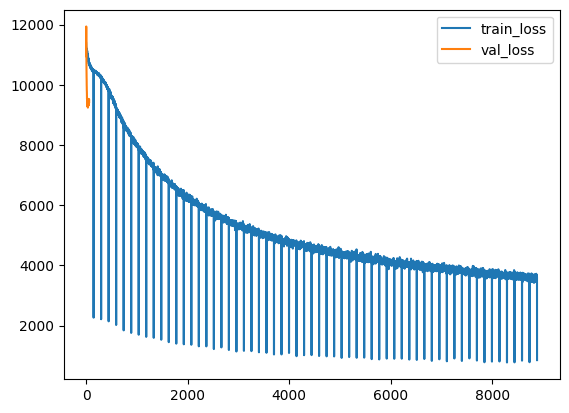

In [16]:
from matplotlib import pyplot as plt
plt.plot(trainStepsLoss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

In [17]:
model.eval()

ModelWithAttention(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (attention): GlobalAttention(
    (attention): Sequential(
      (0): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    

In [24]:
image = read_image(image_paths[100000]).to(torch.float)
image = transform(image).unsqueeze(1).to(device)

output = model(image)
output_cpu = output.cpu().detach().numpy()

label = one_hot_to_label(output_cpu)
print(label)

IjIC9


In [25]:
gt_list[100000]

't2i1Q'

In [20]:
transform(read_image(image_paths[10000]).to(torch.float)).to(device).shape

torch.Size([1, 40, 150])

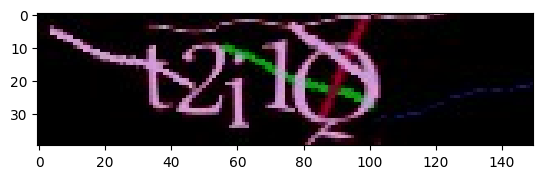

In [26]:
import cv2
imagemm=cv2.imread(image_paths[100000])
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(imagemm)
plt.show()